In [1]:
import os
import time

import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from matplotlib.patches import Patch

In [2]:
def read_picture(file_root='cube_20221019_091444'):
    # 图片文件夹路径
    current_path = os.getcwd()
    folder_path = os.path.join(current_path,'peanut_traning_data',file_root, 'png' )

    # 读取图片
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 以灰度模式读取图片
            image_list.append(image)

    # 将图片转换为NumPy数组
    image_array = np.array(image_list)

    return image_array, image

In [3]:
def KmCluster(image_array):
    """
    聚类，将输入图片中的花生壳、花生区域的像素置为255，背景区域像素值置为0
    """
    data = image_array
    # 将数据重新形状为 (N, M)，其中 N 是样本数，M 是特征数
    N, M = data.shape[0], data.shape[1] * data.shape[2]
    reshaped_data = data.reshape(N, M)
    reshaped_data = np.transpose(reshaped_data, (1, 0))

    # 使用KMeans算法进行聚类，聚类成两类
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(reshaped_data)

    # 获取聚类结果标签
    labels = kmeans.labels_
    # 将聚类结果标签重新形状为3x1024x1280的数组
    reshaped_labels = labels.reshape(1, 1024, 1280)
    if np.count_nonzero(reshaped_labels == 1) > np.count_nonzero(reshaped_labels == 0):
        reshaped_labels = np.where(reshaped_labels == 1, 0, 1)
        

    # 创建一个3x1024x1280的图片，将聚类结果标签赋值给对应位置的像素
    image = np.zeros((3, 1024, 1280))
    image[0][reshaped_labels[0] == 0] = 0  # 第一类赋值为255
    image[1][reshaped_labels[0] == 1] = 255  # 第二类赋值为255

    # 显示图片
    image = np.transpose(image, (1, 2, 0)).astype(np.uint8)
    plt.imshow(image)
    plt.show()
    return image, reshaped_labels

In [4]:
# 定义数据预处理的转换
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # 调整图像大小为64x64像素
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化处理
])


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.res = models.resnet18(pretrained=False)
        self.fc1 = nn.Linear(1000, 2)

    def forward(self, x):
        x = self.res(x)
        x = self.fc1(x)
        return x


model = Net()

In [9]:
def model_predict(image):
    """
    判断花生仁和花生壳：0代表花生仁、1代表花生壳
    :param image: numpy格式的图片数组
    :return: 类别（格式为整数）
    """
    # 预测该区域是花生仁还是花生壳
    global model
    model.eval()
    object_image = Image.fromarray(image)
    image = transform(object_image)
    image = image.unsqueeze(0)
    image = image.repeat(1, 3, 1, 1)
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    
    return predicted.item()


In [10]:
def generate_img(image, img, reshaped_labels):

    # 读取灰度图像
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(image, 20, 100)

    # 进行连通区域分析，提取物体轮廓
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    show_image = np.zeros((3, 1024, 1280))
    temp_image = np.zeros((1, 1024, 1280))
    # 遍历每个轮廓，生成小图片
    for i, contour in enumerate(contours):
        # 获取每个轮廓的边界框
        x, y, w, h = cv2.boundingRect(contour)

        # 提取小图片
        if w>=3 and h>=3:
            object_image = img[y:y+h, x:x+w]
            object_image = cv2.resize(object_image, (64, 64))
            
            # 预测该区域是花生仁还是花生壳
            label = model_predict(object_image)
            # print(label)
            temp_image[:,y:y+h, x:x+w] = int(label) + 1
            # print(np.count_nonzero(temp_image[0] == 2))
            
            
    # 第一类赋值为255
    show_image[0][reshaped_labels[0] == 0] = 0  
    # 第二类赋值为255
    show_image[1][np.logical_and(reshaped_labels[0] == 1, temp_image[0] == 1)] = 255
    # 第三类赋值为255
    show_image[2][np.logical_and(reshaped_labels[0] == 1, temp_image[0] == 2)] = 255
    
    show_image = np.transpose(show_image, (1, 2, 0)).astype(np.uint8)
    return show_image



In [11]:
def main(file_name=os.path.join('peanut_test_data','cube_20221019_091559')):
    # 获取测试集路径
    
    current_path = os.getcwd()
    root = os.path.join(current_path, file_name)
    
    image, img = read_picture(file_root=root)
    image, reshaped_labels = KmCluster(image)
    show_image = generate_img(image, img, reshaped_labels)
    fig, ax = plt.subplots()
    legend_elements = [
        Patch(facecolor='green', edgecolor='blue', label='kernel'),
        Patch(facecolor='blue', edgecolor='green', label='shell')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    plt.imshow(show_image)
    plt.show()
    

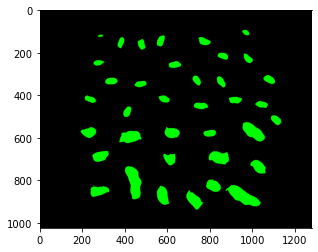

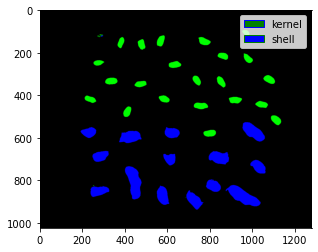

In [13]:
if __name__ == '__main__':
    model = Net()
    model.load_state_dict(torch.load('best.mdl'))
    main(file_name=os.path.join('peanut_test_data','cube_20221019_091559'))